In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sqlalchemy import func
from sqlalchemy.orm import Session
from torch import nn
from transformers import logging

import src
import src.bert.io
import src.db.connect
import src.db.load
from src.bert import utils
from src.bert.pipeline import Pipeline

In [ ]:
# set transformers logging v to error
logging.set_verbosity_error()

pd.set_option("display.max_colwidth", 2048)
pd.set_option("display.max_rows", 50)

# model hyper-parameters
LR = 3e-5
MAX_EPOCHS = 5
BATCH_SIZE = 16

MODEL = "deepset/gbert-large"
TOKENIZER = "deepset/gbert-large"

engine = src.db.connect.make_engine("DB")

# Load & prepare dataset


In [ ]:
df = src.db.load.classification_pop_data(engine)

names = ["none", "antielite", "pplcentr"]

In [ ]:
train, test = train_test_split(
    df[["text", "antielite", "pplcentr", "label"]],
    stratify=df.label,
    test_size=0.30,
    random_state=13389,
)

orig_counts = train.label.value_counts()

train = train.loc[~(train.antielite.between(0.05, 0.49) & (train.label == 0))]
train = train.loc[~(train.pplcentr.between(0.05, 0.49) & (train.label == 0))]


counts = train.label.value_counts()
max_size = max(counts.items(), key=lambda x: x[1])[1]

weights = max(counts) / counts

print("name" + " " * 10 + "orig_count" + " " * 4 + "count" + " " * 6 + "weight\n" + "-" * 52)
for name, orig_count, count, weight in zip(names, orig_counts, counts, weights):
    print(
        f"{name : >10}: {round(orig_count, 4) : > 12} {round(count, 4) : > 8} {round(weight, 4) : > 10}"
    )

weights = torch.Tensor(weights)

train.shape, test.shape

name          orig_count    count      weight
----------------------------------------------------
      none:         3645     2991        1.0
 antielite:          746      746     4.0094
  pplcentr:          197      197    15.1827


((3934, 4), (1967, 4))

# Configure BERT model pipeline

- most parts in here are taken from [this tutorial](https://nbviewer.org/github/skorch-dev/skorch/blob/master/notebooks/Hugging_Face_Finetuning.ipynb).


In [ ]:
pipeline = Pipeline(
    pretrained_model=MODEL,
    tokenizer=TOKENIZER,
    num_labels=df.label.nunique(),
    n_train=len(train),
    criterion=nn.CrossEntropyLoss,
    batch_size=BATCH_SIZE,
    lr=LR,
    max_epochs=MAX_EPOCHS,
)

# Fit model


In [ ]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)

In [ ]:
%time _ = pipeline.fit(train.text, train.label)

  epoch    f1_score    train_loss    valid_acc    valid_loss       dur
-------  ----------  ------------  -----------  ------------  --------
      1      0.5144        0.5089       0.8475        0.4277  148.8233
      2      0.6943        0.3150       0.8526        0.3590  149.0375
      3      0.7201        0.1546       0.8602        0.3704  149.0953
      4      0.7054        0.0944       0.8691        0.4068  149.2113
      5      0.7112        0.0314       0.8793        0.5049  150.2177
CPU times: user 11min 28s, sys: 1min 1s, total: 12min 29s
Wall time: 12min 39s


# Evaluate model


In [ ]:
%%time
with torch.inference_mode():
    y_pred = pipeline.predict(test.text)

CPU times: user 28.6 s, sys: 11.5 ms, total: 28.6 s
Wall time: 28.4 s


In [ ]:
accuracy_score(test.label, y_pred)

0.85866802236909

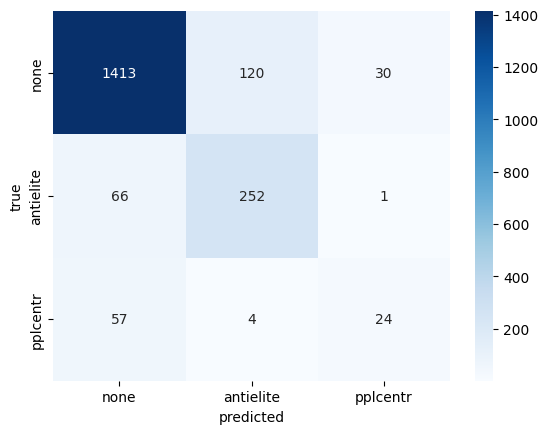

In [ ]:
conf_mat = pd.DataFrame(confusion_matrix(test.label, y_pred))

fig = sns.heatmap(conf_mat, annot=True, fmt=".4g", cmap="Blues")
ticklabels = ["none", "antielite", "pplcentr"]
fig.set_xticklabels(ticklabels)
fig.set_yticklabels(ticklabels)
fig.set_ylabel("true")
fig.set_xlabel("predicted")

plt.show()

In [ ]:
print(classification_report(test.label, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91      1563
           1       0.67      0.79      0.73       319
           2       0.44      0.28      0.34        85

    accuracy                           0.86      1967
   macro avg       0.68      0.66      0.66      1967
weighted avg       0.86      0.86      0.86      1967



In [ ]:
# src.bert.io.save(pipeline, src.PATH / "tmp/multilabel_test_you.model", trim_for_prediction=False)

# Predictions


In [ ]:
pd.set_option("display.max_rows", 75)

In [ ]:
test["pred"] = y_pred

incorrect = test[test.label != test.pred]
incorrect = utils.add_predict_proba(pipeline, incorrect)
incorrect if len(incorrect) <= 50 else incorrect.sample(50)

,text,antielite,pplcentr,label,pred,0,1,2
2200,"Jeder, der in seinem Wahlkreis Träger der Erwachsenenbildung hat, weiß, wie sehr sich diese um Migrantinnen und Migranten kümmern, die ihrerseits ihren Platz in unserer, hoffentlich dann in unserer gemeinsamen Gesellschaft finden wollen.",0.000000,0.500000,2,0,0.9050,0.0003,0.0947
5133,"Es ist der zehnte Jahrestag der Finanzkrise, und die Krisenkosten haben eben nicht die 1 Prozent Superreichen und auch nicht die kriminellen Banker bezahlt, sondern die Menschen, die ihr Geld auf ehrliche Weise verdienen.",0.250000,0.500000,2,0,0.8759,0.0086,0.1155
3007,"Jetzt erlaubt diese Regierung sich, die Mitbestimmung in Unternehmen zu erweitern, vielleicht sogar ein kleines bisschen die Steuern für die Konzerne zu erhöhen.",0.000000,0.000000,0,1,0.0335,0.9660,0.0005
6348,Ohne Not hat der US-Präsident in Syrien ein Riesendesaster angerichtet.,0.333333,0.000000,0,1,0.0214,0.9779,0.0007
1369,Und für die Interessen dieser großen Mehrheit der Frauen setzen wir uns ein.,0.000000,0.333333,0,2,0.0338,0.0005,0.9657
2595,"Aber wenn bei den Cum-Ex-Geschäften der Superreichen ein paar Milliarden Euro unter die Räder kommen, lehnen Sie es ab, genau hinzuschauen.",0.250000,0.000000,0,1,0.0008,0.9990,0.0003
3136,"So, wie der Bericht jetzt ist, stellt er das wahre Ausmaß des Atommülldesasters nicht dar, sondern tut so, als ob alles irgendwie lösbar wäre oder gelöst worden ist.",0.333333,0.000000,0,1,0.0446,0.9551,0.0004
317,"In meinem Wahlkreis kenne ich ausnahmslos ordentliche Leute, die als Sportschützen ihrem Sport nachgehen und ihre Tradition pflegen.",0.000000,0.500000,2,0,0.9993,0.0001,0.0006
2553,"Herr Minister, das ist eine unfassbare Unverfrorenheit.",0.333333,0.000000,0,1,0.0011,0.9981,0.0008
1824,"Das mag zum einen damit zu tun haben, dass es Ihnen möglicherweise gefällt, Sozialdemokraten in Regierungsverantwortung wieder als Feindbild zu haben, und dass Sie so Ihre disparaten Truppen zusammenhalten können.",0.500000,0.000000,1,0,0.8837,0.1158,0.0005


In [ ]:
incorrect[incorrect.pred == 2].head(74)

,text,antielite,pplcentr,label,pred,0,1,2
4825,"– Ja, klar. – Aber die Bürger wollen doch nicht hören, wofür wir nicht zuständig sind, sondern, was wir machen, welche Probleme wir lösen, was wir erreichen.",0.00,0.000000,0,2,0.2794,0.0022,0.7184
4098,"Ich sage: Diese Äußerungen sind ein Hohn für die Tausenden Menschen, die wegen der Stickoxidemissionen in unserem Land jedes Jahr vorzeitig sterben, und für Millionen betrogener Autofahrer.",0.25,0.000000,0,2,0.4134,0.1080,0.4785
2767,"Das erwarten die Menschen von der Politik heute, und nicht die Nummer, die Sie hier ablaufen lassen.",0.25,0.250000,0,2,0.0114,0.0213,0.9673
687,"Lassen Sie uns so weitermachen – für die Petitionen, für die Bürgerinnen und Bürger und für die Demokratie in diesem Land.",0.00,0.000000,0,2,0.4712,0.0020,0.5268
5724,"Ich denke, die vielen Bürgerinnen und Bürger in Deutschland, die gemäß Bundesverkehrswegeplan endlich eine Ortsumfahrung oder eine Entlastung ihres staugeplagten Alltags bekommen, halten diese Projekte für überhaupt nicht überflüssig.",0.00,0.000000,0,2,0.3028,0.0007,0.6966
5026,Die Zeche zahlt die große Mehrheit der Bürger.,0.00,0.000000,0,2,0.0045,0.0024,0.9931
5812,"Wir, die AfD, sind die Partei der Demokratie, der Souveränität, der Toleranz und des Respekts vor fremden Völkern und Kulturen.",0.00,0.000000,0,2,0.0941,0.0035,0.9024
1369,Und für die Interessen dieser großen Mehrheit der Frauen setzen wir uns ein.,0.00,0.333333,0,2,0.0338,0.0005,0.9657
1133,"Machen Sie Platz für neue Gewerkschaften, Platz für die, die die wirklichen Arbeitnehmerinteressen vertreten, Platz für AVA und ALARM!",0.00,0.250000,0,2,0.0387,0.0076,0.9537
2105,Gerade die Alleinerziehenden leisten besonders viel.,0.00,0.250000,0,2,0.1175,0.0008,0.8817


In [ ]:
correct = test[test.label == test.pred]
correct = utils.add_predict_proba(pipeline, correct)
correct if len(correct) <= 50 else correct.sample(50)

,text,antielite,pplcentr,label,pred,0,1,2
2951,"Es geht nicht, dass man von „Diktat“ redet, wissend, dass hinter einer gemeinsamen Lösung in der EU nicht nur irgendwelche Verhandler stehen.",0.000000,0.000000,0,0,0.9994,0.0005,0.0001
584,"Entscheidend ist nicht die Frage: „Wo gehen wir rein?“, sondern die Frage, mit welchen klebrigen Fingern dieser Staat und der sogenannte Bundeswirtschaftsminister – ich will ja verhindern, dass ihr gleich applaudiert – da reingehen.",0.750000,0.000000,1,1,0.0254,0.9744,0.0003
6422,"Die Menschen in unserem Land werden, wo Bedarf ist, sehr schnell unaufgefordert, freiwillig und sehr kreativ tätig.",0.000000,0.500000,2,2,0.0686,0.0006,0.9308
5552,"Deutschland ist auf der anderen Seite – ganz im Gegensatz zu den falschen Aussagen, die die AfD hier immer verbreitet – das Land, das auch am meisten wirtschaftlich von diesem Binnenmarkt profitiert hat.",0.500000,0.000000,1,1,0.1024,0.8971,0.0005
4466,"Die Europäische Forschungsvereinigung für Umwelt und Gesundheit im Transportsektor – das wurde eben schon angesprochen –, finanziert von VW, Daimler und BMW, hat das finanziert, um eine Belastung am Arbeitsplatz zu untersuchen.",0.000000,0.000000,0,0,0.9996,0.0003,0.0001
1034,Für diese Demokratie sind Antirassismus und die Gestaltung unserer Einwanderungsgesellschaft zentral.,0.000000,0.000000,0,0,0.9994,0.0002,0.0004
1420,Wie naiv ist das denn?,0.000000,0.000000,0,0,0.9996,0.0003,0.0001
6352,"Und die Leute, die dort sitzen, sind die Leute, die Boris Johnson in die Downing Street gebracht haben.",0.000000,0.000000,0,0,0.9913,0.0079,0.0008
2100,"Eine weitere Diskriminierung bedeutet die Einführung des Bildungs- und Teilhabepakets als Sachleistung wegen der Unterstellung, dass Eltern das Geld eher vertrinken und verrauchen, als es bei ihren Kindern ankommen zu lassen.",0.000000,0.250000,0,0,0.9997,0.0001,0.0002
6510,"Das sind Säuglinge und Kinder und die chronisch Kranken, die sich nicht impfen lassen können.",0.000000,0.000000,0,0,0.9975,0.0002,0.0024
